In [142]:
import gym
import gym_sokoban
import numpy as np
from gym.spaces.discrete import Discrete
from gym_sokoban.envs import SokobanEnv
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
%matplotlib inline

In [3]:
class SokobanEnvFixated(SokobanEnv): 
    def __init__(self):
        SokobanEnv.__init__(self,
                            dim_room=(10, 10), 
                            max_steps=40, 
                            num_boxes=4, 
                            num_gen_steps=None, 
                            reset=True)
        self.action_space = Discrete(5) # limit to push actions

    def reset(self, second_player=False, render_mode='rgb_array'):

        self.room_fixed = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                    [0, 0, 0, 1, 1, 0, 1, 0, 0, 0],
                                    [0, 1, 1, 1, 1, 2, 1, 1, 1, 0],
                                    [0, 1, 1, 1, 2, 1, 1, 1, 1, 0],
                                    [0, 1, 1, 1, 0, 1, 1, 2, 1, 0],
                                    [0, 2, 1, 0, 0, 0, 0, 0, 0, 0],
                                    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
                                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
        self.room_state = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                    [0, 0, 0, 1, 1, 0, 1, 0, 0, 0],
                                    [0, 1, 1, 4, 5, 2, 1, 1, 1, 0],
                                    [0, 1, 1, 1, 2, 4, 1, 4, 1, 0],
                                    [0, 1, 1, 1, 0, 1, 1, 2, 1, 0],
                                    [0, 2, 4, 0, 0, 0, 0, 0, 0, 0],
                                    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
                                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
        self.box_mapping = {(6, 7): (5, 7), (5, 4): (5, 5), (4, 5): (4, 3), (7, 1): (7, 2)}

        self.player_position = np.argwhere(self.room_state == 5)[0]
        self.num_env_steps = 0
        self.reward_last = 0
        self.boxes_on_target = 0

        starting_observation = self.render(render_mode)
        return starting_observation # Close environment after testing

In [169]:
UP, DOWN, LEFT, RIGHT = 1, 2, 3, 4

def render_path(env, path, saveAs=None):
    """
    Renders the Sokoban environment and overlays the path with arrows and step numbers.

    Args:
        env: The Sokoban environment.
        path: List of actions [UP, DOWN, LEFT, RIGHT] representing the agent's trajectory.
        saveAs: Saves the plot with given name.
    """
    image = env.render("rgb_array")

    plt.figure(dpi=300)
    plt.imshow(image, origin='upper')
    plt.axis('off')

    # Convert path to coordinates
    findPlayer = lambda room_state: next((x, y) for y, row in enumerate(room_state) for x, val in enumerate(row) if val == 5)
    player_coordinates = []
    directions = {UP:(0,-1), DOWN:(0,1), LEFT:(-1,0), RIGHT:(1,0)}
    for action in path:
        start = findPlayer(env.room_state)
        env.step(action)
        end = findPlayer(env.room_state)
        if start == end:
            dx = start[0] + directions.get(action)[0]
            dy = start[1] + directions.get(action)[1]
            end = (dx, dy)
        player_coordinates.append((start,end))

    # Scaling for element positions in plot
    scale_begin = lambda a : a * 16
    scale = lambda a : scale_begin(a) + 8

    # Mark the final position
    img = mpimg.imread('elements/player.png')
    final = findPlayer(env.room_state)
    img_player = plt.imshow(img, alpha=0.2, zorder=1)
    transform = mpl.transforms.Affine2D().translate(scale_begin(final[0]), scale_begin(final[1]))
    img_player.set_transform(transform + plt.gca().transData)

    # Draw Arrows
    mid_points = []
    for coordinates in player_coordinates:
        start = coordinates[0]
        end = coordinates[1]

        scale_d = lambda a,b : scale(a) - scale(b)
        scale_mid = lambda a,b: (scale(a) + scale(b)) / 2
        plt.arrow(
            scale(start[0]), scale(start[1]),
            scale_d(end[0], start[0]), scale_d(end[1], start[1]),
            head_width=2,
            head_length=2,
            fc='green',
            ec='green',
            length_includes_head=True
        )

        mid_points.append((scale_mid(end[0], start[0]), scale_mid(end[1], start[1])))

    # Add step numbers
    mid_index_dict = {}
    for i, mid in enumerate(mid_points):
        mid_index_dict.setdefault(mid, []).append(i) 
    for mid, indexes in mid_index_dict.items():
        limited = indexes[:4]
        parts = []

        for i, num in enumerate(limited):
            parts.append(str(num+1))
            if i % 2 == 1 and i != len(limited) - 1:
                parts.append('\n')
            elif i != len(limited) - 1:
                parts.append(', ')

        if len(indexes) > 4:
            parts.append('...')

        step_numbers = ''.join(parts)
        plt.text(mid[0], mid[1], step_numbers, color='white', fontsize=4,
                 ha='center', va='center', bbox=dict(boxstyle="round,pad=0.2", fc="black", ec="none", alpha=0.7))

    if saveAs is not None:
        plt.savefig(saveAs + ".png" ,bbox_inches='tight')

    plt.show()

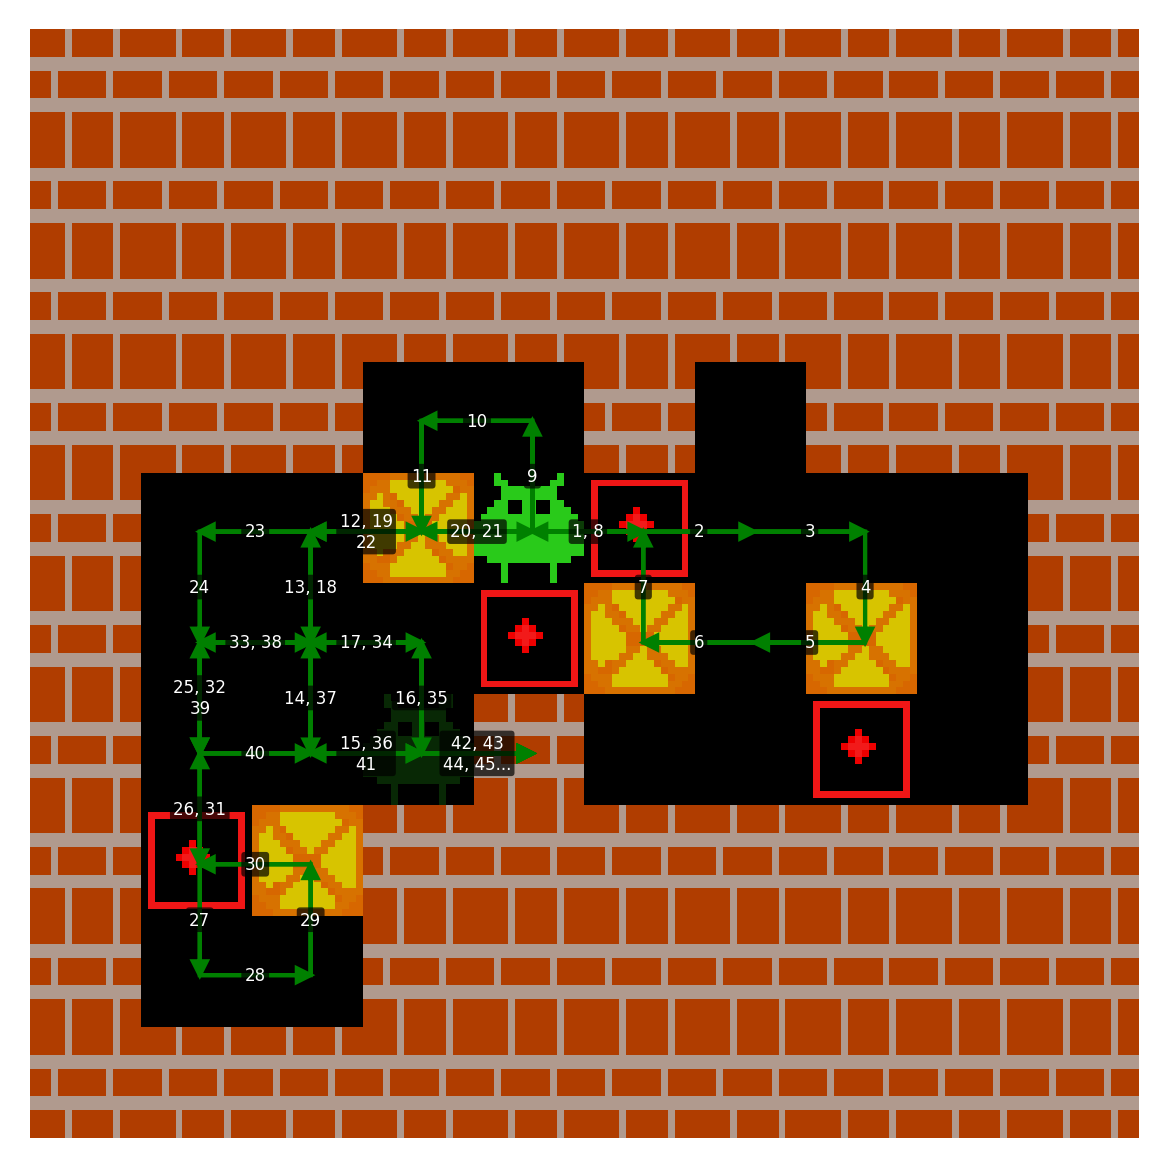

In [170]:
# Human attempt
env = SokobanEnvFixated()
path = [RIGHT, RIGHT, RIGHT, DOWN, LEFT, LEFT, UP, LEFT, UP, LEFT, DOWN, LEFT, DOWN, DOWN, RIGHT, UP, LEFT, UP, RIGHT, RIGHT, LEFT, LEFT, LEFT, DOWN, DOWN, DOWN, DOWN, RIGHT, UP, LEFT, UP, UP, RIGHT, RIGHT, DOWN, LEFT, UP, LEFT, DOWN, RIGHT, RIGHT, RIGHT, RIGHT, RIGHT, RIGHT, RIGHT, RIGHT, RIGHT]
render_path(env, path)